<h1> Bracket Calc </h1>

<h3> This tool predicts your chances of making top 8 at a bracket
given a certain selection of characters.</h3>

Author - Muna N (#INF)

<H3> Setup </H3>

In [5]:
#import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import pickle
import seaborn as sns
from sklearn import metrics

In [7]:
df = pd.read_excel('Offline Data.xlsx').drop(['Unnamed: 0', 'Offline'], axis = 1)
df.tail()

,Tournament,Placement,Participants,DQ_Wins,Winning_Sets,Losing_Sets,Games_Won,Games_Lost,Game_3+,Sweeps,Chars_Won,Chars_Lost,Chars_All,Tourney_Win,Top_8
512,617,7,34,0,4,2,9,7,4,2,"Falco, Kirby, Mario, Terry","Ice Climbers, Falco","Falco, Ice Climbers, Kirby, Mario, Terry",0,1
513,618,9,25,0,3,2,7,5,2,3,"King Dedede, Mario, Mii Brawler","Shulk, Wario","King Dedede, Shulk, Mario, Mii Brawler, Wario",0,0
514,619,9,18,0,1,2,4,5,3,0,Pikachu,"Yoshi, Sephiroth","Pikachu, Yoshi, Sephiroth",0,0
515,620,2,13,0,4,2,10,7,2,4,"Rosalina & Luma, Bayonetta, Mr. Game & Watch, ...",Mega Man,"Rosalina & Luma, Mega Man, Bayonetta, Mr. Game...",0,1
516,621,13,43,0,3,2,7,5,2,3,"Zelda, Pichu, Mr. Game & Watch","Peach, Dark Samus","Peach, Zelda, Pichu, Mr. Game & Watch, Dark Samus",0,0


<h3>EDA</h3>

In [10]:
#correlation matrix

numeric = df.drop(['Chars_Won', 'Chars_Lost', 'Chars_All'], axis = 1)
numeric.corr()

,Tournament,Placement,Participants,DQ_Wins,Winning_Sets,Losing_Sets,Games_Won,Games_Lost,Game_3+,Sweeps,Tourney_Win,Top_8
Tournament,1.000000,-0.030811,0.026793,-0.091221,-0.005209,0.074336,-0.013040,0.036426,0.013852,0.006434,-0.097870,0.040745
Placement,-0.030811,1.000000,0.826169,0.102934,-0.130472,0.064843,-0.061794,0.075018,-0.017250,-0.092796,-0.069360,-0.266541
Participants,0.026793,0.826169,1.000000,0.081256,0.022573,0.031912,0.053854,0.124114,0.070449,-0.031120,-0.046986,-0.184254
DQ_Wins,-0.091221,0.102934,0.081256,1.000000,-0.073420,0.022484,-0.054081,0.036676,-0.000704,-0.064940,0.013706,-0.072471
Winning_Sets,-0.005209,-0.130472,0.022573,-0.073420,1.000000,-0.312666,0.910264,0.305478,0.407404,0.521530,0.277407,0.498391
Losing_Sets,0.074336,0.064843,0.031912,0.022484,-0.312666,1.000000,-0.319515,0.400606,-0.036387,0.047759,-0.759441,-0.169473
Games_Won,-0.013040,-0.061794,0.053854,-0.054081,0.910264,-0.319515,1.000000,0.415396,0.580797,0.272928,0.336932,0.487216
Games_Lost,0.036426,0.075018,0.124114,0.036676,0.305478,0.400606,0.415396,1.000000,0.635813,-0.143236,-0.159938,0.292174
Game_3+,0.013852,-0.017250,0.070449,-0.000704,0.407404,-0.036387,0.580797,0.635813,1.000000,-0.514501,0.085991,0.314960
Sweeps,0.006434,-0.092796,-0.031120,-0.064940,0.521530,0.047759,0.272928,-0.143236,-0.514501,1.000000,-0.049541,0.153970


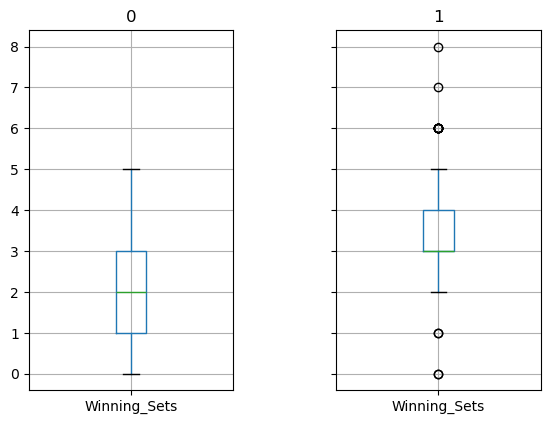

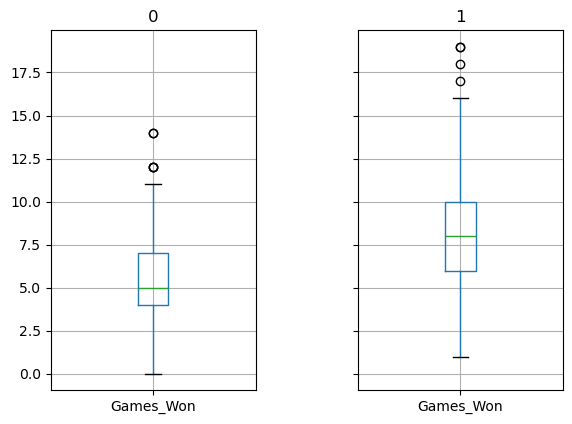

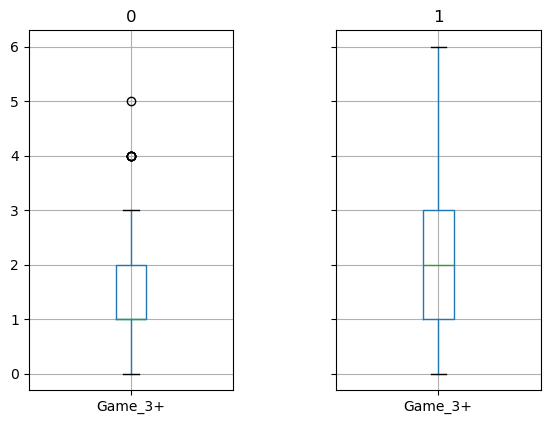

In [12]:
#distributions

df.groupby('Top_8').boxplot(column=['Winning_Sets'])
plt.subplots_adjust(wspace = 0.5, hspace = 1)

df.groupby('Top_8').boxplot(column=['Games_Won'])
plt.subplots_adjust(wspace = 0.5, hspace = 1)

df.groupby('Top_8').boxplot(column=['Game_3+'])
plt.subplots_adjust(wspace = 0.5, hspace = 1)

<h3> Text Preprocessing </h3>

In [15]:
#nltk.download('all')

<h3>Pipeline Building & Model Training</h3>

In [18]:
#train/test split, 70-30
x = df[['Winning_Sets', 'Games_Won', 'Game_3+', 'Chars_All']]

y = df['Top_8']


X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                test_size=0.3, 
                                                random_state=0)

In [20]:
x.columns

Index(['Winning_Sets', 'Games_Won', 'Game_3+', 'Chars_All'], dtype='object')

In [22]:
#Using a class for the lemmatizing of strings
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [24]:
#TFIDF-vectorizing the list of characters we play
tvec = TfidfVectorizer(sublinear_tf=True, min_df=2,
                        ngram_range=(1, 2), 
                        stop_words='english', tokenizer = LemmaTokenizer())

In [26]:
#taking our vectorizer and putting it into a ColumnTransformer
column_transformer = ColumnTransformer(transformers = [
    ('tfidf', tvec, 'Chars_All'),
    ("num_preprocess", StandardScaler(), ['Winning_Sets', 'Games_Won', 'Game_3+'])
])

In [28]:
#creating pipeline with the vectorizer and an RF model

rf = RandomForestClassifier(n_estimators=100, random_state=0)

model = Pipeline(steps = [
    ('preproc', column_transformer),
    ('classifier', rf)
])
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english',
                                                                  sublinear_tf=True,
                                                                  tokenizer=<__main__.LemmaTokenizer object at 0x16aebf770>),
                                                  'Chars_All'),
                                                 ('num_preprocess',
                                                  StandardScaler(),
                                                  ['Winning_Sets', 'Games_Won',
                                                   'Game_3+'])])),
                ('classifier', RandomForestClassifier(random_state=0))])

<h3>Making Predictions</h3>

In [31]:
#making predictions with the model

y_pred = model.predict(X_test)

#full classification metrics report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred))
print()

print('Model Accuracy:', round(model.score(X_test, y_test), 3))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.82      0.77      0.80        83
           1       0.76      0.81      0.78        73

    accuracy                           0.79       156
   macro avg       0.79      0.79      0.79       156
weighted avg       0.79      0.79      0.79       156


Model Accuracy: 0.788


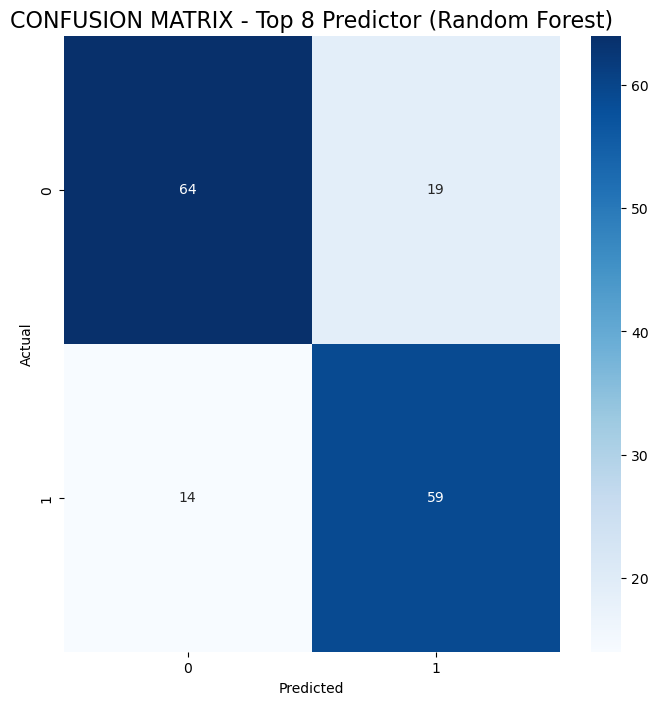

In [33]:
#graphing station for confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Top 8 Predictor (Random Forest)", size=16)
plt.show()
print()

In [35]:
#BATCH BUILDING - creating a sample bracket run to feed the model

set_w = int(input('How many sets did you win:'))
game_w = int(input('How many games did you win:'))
game3 = int(input('How many sets did you play that went to game 3 or more:'))
char_str = input('Please enter the list of characters you played against: ')

new_data = pd.DataFrame({
    'Winning_Sets': [set_w],
    'Games_Won': [game_w],
    'Game_3+': [game3],
    'Chars_All': [char_str]
})

#predicting the single batch
bracket_calc = model.predict(new_data)
bracket_p = model.predict_proba(new_data)[0][1]

print('Top 8 Prediction:', bracket_calc, 'with a success probability of:',
      round((bracket_p * 100),2))

How many sets did you win: 4
How many games did you win: 3
How many sets did you play that went to game 3 or more: 2
Please enter the list of characters you played against:  Bowser, Lucas, Zelda, Yoshi


Top 8 Prediction: [1] with a success probability of: 61.0


<h3>Creating the Model File (for future applications)</h3>

In [38]:
# Save to file in the current working directory
pkl_filename = "model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [40]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [42]:
# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(X_test)

Test score: 78.85 %


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [44]:
##loading the model from the saved file
pkl_filename = "model.pkl"
with open(pkl_filename, 'rb') as f_in:
    model = pickle.load(f_in)
    print(model)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english',
                                                                  sublinear_tf=True,
                                                                  tokenizer=<__main__.LemmaTokenizer object at 0x179e79d60>),
                                                  'Chars_All'),
                                                 ('num_preprocess',
                                                  StandardScaler(),
                                                  ['Winning_Sets', 'Games_Won',
                                                   'Game_3+'])])),
                ('classifi

In [50]:
#using the model to predict target values
single_predict = model.predict(pd.DataFrame({
"Winning_Sets": [2],
"Games_Won": [5],
"Game_3+": [2],
"Chars_All": ["Mario, Luigi, Fox, Cloud"]
}))
single_predict

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


array([1])